In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss
from sklearn.metrics import classification_report,confusion_matrix, precision_recall_fscore_support 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
df = pd.read_csv('kidney_disease.csv')
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [3]:
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
df[['appet']] = df[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
df['classification'] = df['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
df.rename(columns={'classification':'class'},inplace=True)

# Further cleaning
df['pe'] = df['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
df['appet'] = df['appet'].replace(to_replace='no',value=0)
df['cad'] = df['cad'].replace(to_replace='\tno',value=0)
df['dm'] = df['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
df.drop('id',axis=1,inplace=True)


df = df.replace("?", np.nan)
df = df.replace("	?", np.nan)
df = df.fillna(method='ffill')
df = df.fillna(method='backfill')
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.0,...,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,121.0,...,38,6000,5.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31,7500,5.2,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
df = df.dropna(axis=0)
df['class'].value_counts()

1.0    250
0.0    150
Name: class, dtype: int64

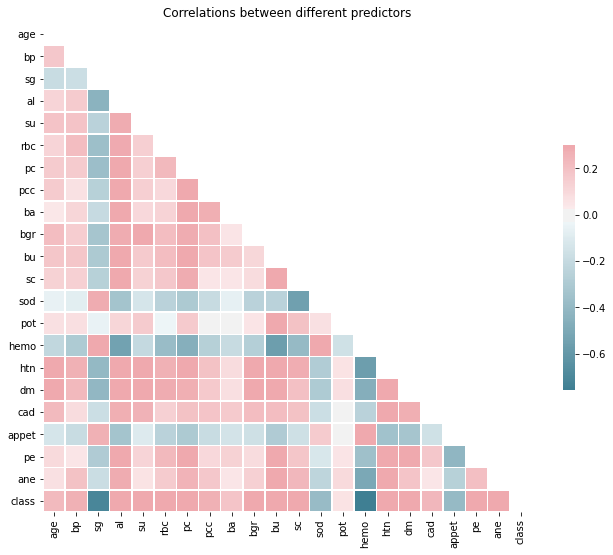

In [5]:
corr_df = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()

In [6]:
X = df.drop("class", axis=1)
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
classifiers = [
    KNeighborsClassifier(5),
    SVC(C=.1, degree=2, kernel='poly', probability=True),
    NuSVC(nu=.1, degree=2, kernel='poly', probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    LogisticRegression()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'Log Loss']
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    try:
        print('****Results****')
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        print("Accuracy: {:.4%}".format(acc))
#         print("accuracy_score: \n",accuracy_score(y_test, train_predictions))
        print("precision_score: \n",precision_score(y_test, train_predictions))
        print("f1_score: \n",f1_score(y_test, train_predictions))
#         print("classification_report: \n",classification_report(y_test, train_predictions))
        print("confusion_matrix: \n",confusion_matrix(y_test, train_predictions))
        print("log_loss: \n",log_loss(y_test, train_predictions))
        log_entry = pd.DataFrame([[name, acc*100, log_loss(y_test, train_predictions)]], columns=log_cols)
        log = log.append(log_entry)
    except Exception as e:
        print (e)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 71.2500%
precision_score: 
 0.8536585365853658
f1_score: 
 0.7526881720430108
confusion_matrix: 
 [[22  6]
 [17 35]]
log_loss: 
 9.929958183344088
SVC
****Results****
Accuracy: 65.0000%
precision_score: 
 0.65
f1_score: 
 0.787878787878788
confusion_matrix: 
 [[ 0 28]
 [ 0 52]]
log_loss: 
 12.088851597319309
NuSVC
****Results****
Accuracy: 33.7500%
precision_score: 
 0.4897959183673469
f1_score: 
 0.4752475247524753
confusion_matrix: 
 [[ 3 25]
 [28 24]]
log_loss: 
 22.882189235825262
DecisionTreeClassifier
****Results****
Accuracy: 98.7500%
precision_score: 
 1.0
f1_score: 
 0.9902912621359222
confusion_matrix: 
 [[28  0]
 [ 1 51]]
log_loss: 
 0.43173470493638444
RandomForestClassifier
****Results****
Accuracy: 100.0000%
precision_score: 
 1.0
f1_score: 
 1.0
confusion_matrix: 
 [[28  0]
 [ 0 52]]
log_loss: 
 9.992007221626413e-16
AdaBoostClassifier
****Results****
Accuracy: 98.7500%
precision_score: 
 1.0
f1_score: 
 0.9902912621359222
c

G:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


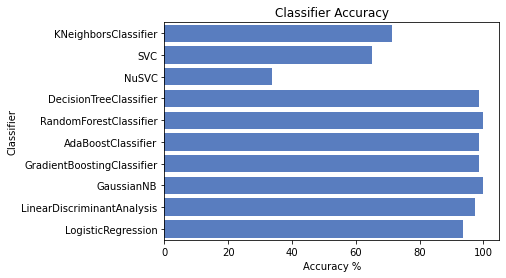

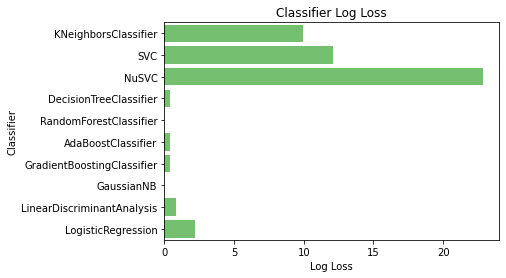

In [8]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10,criterion ='entropy',random_state=0)
rfc.fit(X_train,y_train)

y_pred=rfc.predict(X_test)
y_pred

array([1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.])

In [16]:
y_test.values

array([1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.])

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9875

In [18]:
import pickle
pickle.dump(dt,open('outcome.pkl','wb'))
model=pickle.load(open('outcome.pkl','rb'))

# Thank You